# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [3]:
# import external libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold


# import py files.
from data_cleaning import *
from non_generalized_viz import *
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

# Configure matplotlib for jupyter.
%matplotlib inline

/home/corey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Data Cleaning

In [4]:
df = pd.read_csv('student_data.csv')

In [5]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [6]:
# df.rename(columns={"PAY_0":"PAY_1"}, inplace=True)

#Imputes values to combine "other"/"unknown" fields in the marriage and education columns.
df= replace_unknowns(df)

## 2. EDA

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,23999.0,15027.353931,8654.746941,1.0,7506.0,15027.0,22531.5,30000.0
LIMIT_BAL,23999.0,167825.729405,129915.115993,10000.0,50000.0,140000.0,240000.0,1000000.0
SEX,23999.0,1.603608,0.489158,1.0,1.0,2.0,2.0,2.0
EDUCATION,23999.0,1.783408,0.730617,0.0,1.0,2.0,2.0,3.0
MARRIAGE,23999.0,1.517897,0.524588,0.0,1.0,2.0,2.0,2.0
AGE,23999.0,35.523230,9.253986,21.0,28.0,34.0,42.0,79.0
PAY_1,23999.0,-0.014959,1.120903,-2.0,-1.0,0.0,0.0,8.0
PAY_2,23999.0,-0.134839,1.193044,-2.0,-1.0,0.0,0.0,8.0
PAY_3,23999.0,-0.165632,1.193515,-2.0,-1.0,0.0,0.0,8.0
PAY_4,23999.0,-0.217092,1.168719,-2.0,-1.0,0.0,0.0,8.0


<Figure size 1440x1080 with 0 Axes>

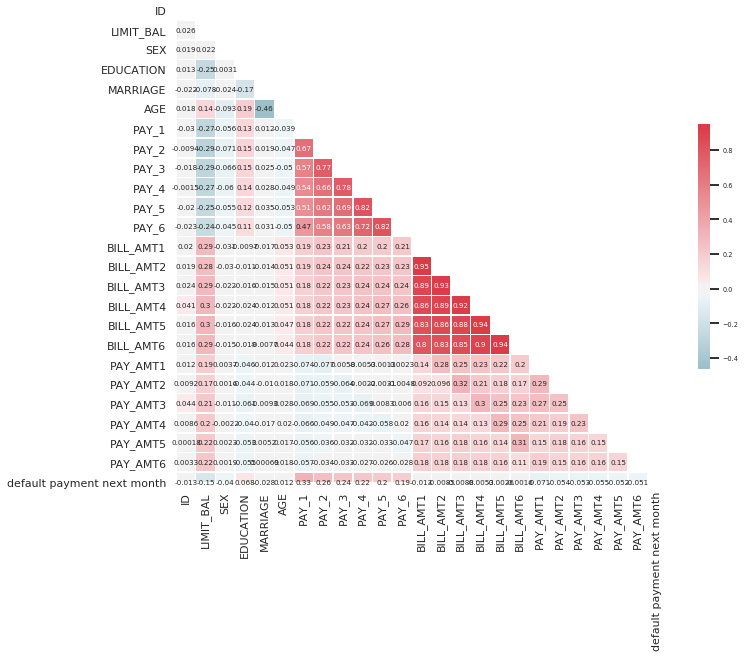

In [5]:
trimmed_heatmap(df, df.columns, font_scale=.4, figsize=(20,15))
# trimmed_heatmap(df, selection, font_scale=.4, figsize=(20,15))

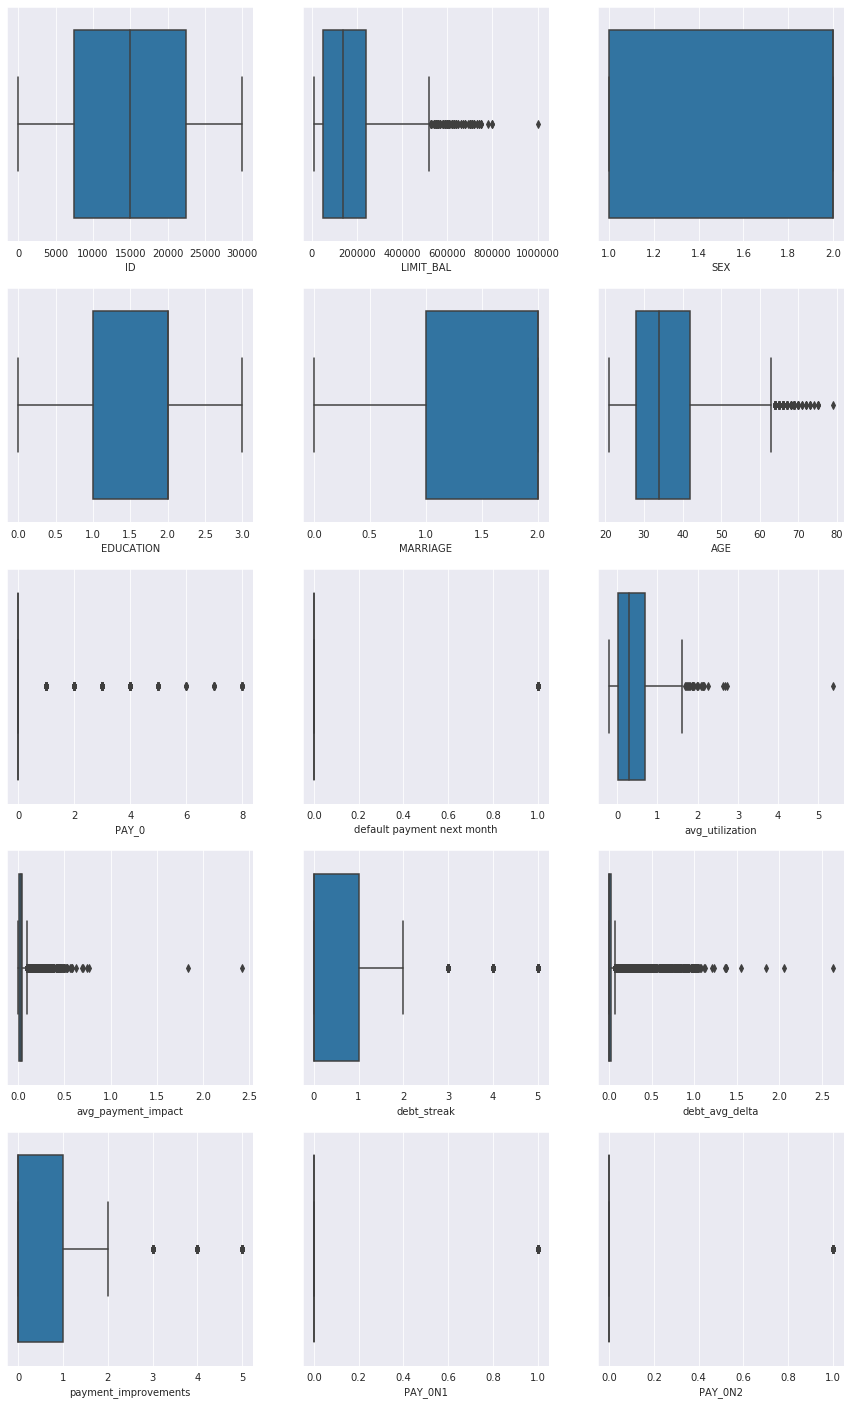

In [10]:
graph = Multiplot(df[selection], 3, figsize=(15,25))
graph.sb_multiplot(sns.boxplot)

#looking at the boxplots, there are two outliers that should be taken care of. One in
# limit balance and the otther in average utilization.

Optimization terminated successfully.
         Current function value: 0.601439
         Iterations 6
PAY_0 predicting default_payment_next_month:
Pseudo R2: 0.12866973365323175, Log Likelihood: -20889.774497488153, Null Log Likelihood: -23974.57692485863:
Coeficient: 9.261892160814021, Intercept: -0.6919480579804156

P-values:
Intercept    0.0
PAY_0        0.0
dtype: float64
[0.00000000e+00 2.87910633e-05 5.75821265e-05 ... 9.99913627e-01
 9.99942418e-01 9.99971209e-01]


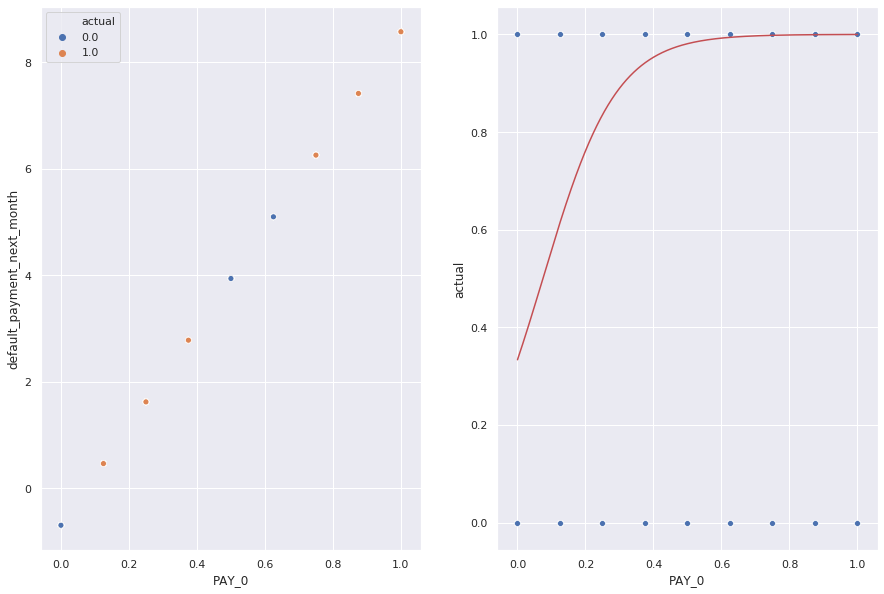

In [205]:
graph = LinearityTest(data.get_df().reset_index(), 2, figsize=(15,10))
graph.sb_linearity_test('PAY_0', 'default payment next month', True)

#It appears that there is minimal linear relationship of the log odds for this dataset.
#The strongest performing variable in this regards was Pay 0 which had a pseudo R squared
#of .12.

## 3. Feature Engineering

In [7]:
df = calculate_utilization(df)
df = combine_pay_columns(df)
df = split_pay_columns(df)

In [11]:
#Removes outliers. Should not be used on the prediction data.
df=df[df["avg_utilization"]<5.3]
df = df[df["LIMIT_BAL"]<800000]

## 4. Feature Selection

In [9]:
excluded = exclude_columns(["PAY_AMT", "BILL_AMT", "payment_impact","utilization"], 1, 7)
excluded2 = exclude_columns(["PAY_"], 2, 7)
selection = df.drop(columns = [*excluded, *excluded2]).columns
df_trimmed = df[selection]

# df.to_pickle("df_untrimmed.pickle")
# df_trimmed.to_pickle("df_trimmed.pickle")

In [8]:
df[selection].columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'default payment next month', 'avg_utilization', 'avg_payment_impact',
       'debt_streak', 'debt_avg_delta', 'payment_improvements', 'PAY_0N1',
       'PAY_0N2'],
      dtype='object')

In [12]:
#Creating column selection dictionaries for the data from lists of column names.

#Lists to go in the dictionaries.
nom = ["SEX", "EDUCATION", "MARRIAGE",]
reg_dummies = []
pay_dummies=["PAY_0N1", "PAY_0N2"]
untr = ["LIMIT_BAL", "avg_utilization", "avg_payment_impact", "debt_streak",
        "debt_avg_delta","PAY_0",'payment_improvements']
# tran = {"logged": {"ID":20,}
tran = {}
polyc = [*nom, *pay_dummies, "PAY_0"]

#The dicts that come into the arguments.
target_col = "default payment next month"
categorical = {
    "nominal_features":nom, "standard_dummies":reg_dummies, "impute_dummies":pay_dummies
}

continuous = {"untransformed":untr, "transformed": tran}
polynomial = {"method":"eliminate", "columns":polyc}

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [13]:
full_value_counts(df, target_col)

#Since the amount of default observations is significantly smaller we will be performing
# an upsample with replacement on the data. Downsampling resulted in a less effective
# model as did SMOTE. Tomek performed the worst for this data set, but still better than
# not balancing the class at all.

There are 2 unique values with 0 nan values making up 0.0%
18687-0.0 --77.88%
5308-1.0 --22.12%


In [15]:
to_drop =['LIMIT_BAL', 'LIMIT_BAL avg_utilization', 'LIMIT_BAL^2', 'avg_payment_impact',
 'LIMIT_BAL debt_streak', 'LIMIT_BAL debt_avg_delta', 'LIMIT_BAL payment_improvements',
         "debt_streak", 'debt_streak payment_improvements', 'avg_payment_impact debt_streak',
         'avg_payment_impact^2', 'avg_payment_impact debt_avg_delta',
    'avg_payment_impact payment_improvements', 'avg_utilization avg_payment_impact',
         'debt_avg_delta payment_improvements', 'debt_avg_delta^2', 'debt_streak debt_avg_delta',
         'avg_utilization debt_streak', 'avg_utilization debt_avg_delta',
         'payment_improvements^2', 'avg_utilization payment_improvements', 'avg_utilization^2',]
data = DataPreprocessor(df, target_col, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class="upsample", scale_type="minmax", poly_degree=2)
data.column_drop(to_drop)
data.get_X_test()

Creating Dummies
Getting polynomial features of degree 2
Performing upsample
Using Min/Max scaler
Adding ['LIMIT_BAL', 'avg_payment_impact', 'debt_streak', 'LIMIT_BAL^2', 'LIMIT_BAL avg_utilization', 'LIMIT_BAL debt_streak', 'LIMIT_BAL debt_avg_delta', 'LIMIT_BAL payment_improvements', 'avg_utilization^2', 'avg_utilization avg_payment_impact', 'avg_utilization debt_streak', 'avg_utilization debt_avg_delta', 'avg_utilization payment_improvements', 'avg_payment_impact^2', 'avg_payment_impact debt_streak', 'avg_payment_impact debt_avg_delta', 'avg_payment_impact payment_improvements', 'debt_streak debt_avg_delta', 'debt_streak payment_improvements', 'debt_avg_delta^2', 'debt_avg_delta payment_improvements', 'payment_improvements^2']


,avg_utilization,debt_avg_delta,PAY_0,payment_improvements,PAY_0N1,PAY_0N2,SEX_2.0,EDUCATION_1.0,EDUCATION_2.0,EDUCATION_3.0,MARRIAGE_1.0,MARRIAGE_2.0,LIMIT_BAL avg_payment_impact,debt_streak^2
719,0.194299,0.077916,0.000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.015409,0.36
4173,0.082002,0.000000,0.000,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.012164,0.00
16266,0.087392,0.000000,0.000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.004681,0.00
10099,0.391207,0.003399,0.000,0.2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.012500,0.04
7511,0.068395,0.000000,0.125,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23176,0.069236,0.000000,0.125,0.4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.000872,0.00
6873,0.101895,0.018268,0.000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.010647,0.64
15874,0.077730,0.000000,0.000,0.2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.018109,0.00
23745,0.091541,0.000158,0.000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.029868,0.04


In [ ]:
#Even with interactions, with the exception of Pay0 the condtions for a logistic
#relationship are not met.

# for column in df2.columns:
#     graph = LinearityTest(df2, 2, figsize=(15,10))
#     graph.sb_linearity_test(column, 'default payment next month', True)

In [163]:
logreg = LogisticRegression(fit_intercept=False, C=1e12,
                            solver='liblinear', random_state=data.random_state)
model_log = logreg.fit(data.get_X_train(), data.y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=124, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [169]:
pd.concat([pd.Series(data.get_X_train().columns), pd.Series(logreg.coef_[0])],axis=1)

,0,1
0,avg_utilization,1.301955
1,debt_avg_delta,1.020311
2,PAY_0,8.812183
3,payment_improvements,0.756249
4,PAY_0N1,0.122332
5,PAY_0N2,0.122332
6,SEX_2.0,-0.205969
7,EDUCATION_1.0,-0.041468
8,EDUCATION_2.0,0.014699
9,EDUCATION_3.0,0.011178


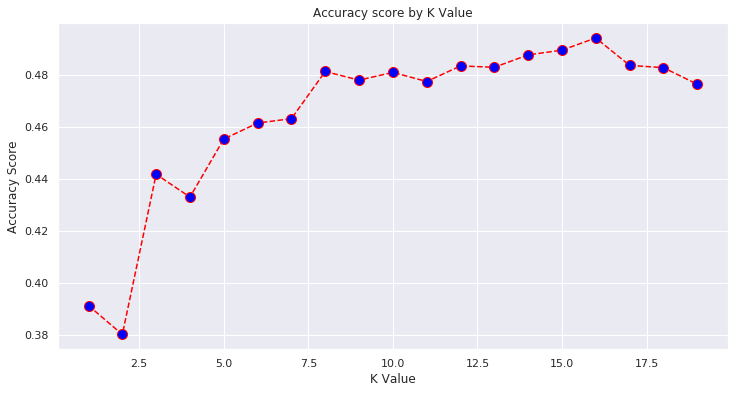

In [187]:
plot_knn_f1s(data.get_X_train(), data.get_X_test(), data.y_train, data.y_test)

In [182]:
knn=KNeighborsClassifier(n_neighbors=16)
knn.fit(data.get_X_train(),data.y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=16, p=2,
                     weights='uniform')

In [194]:
forest = RandomForestClassifier(random_state=data.random_state, n_jobs=-1,)

In [94]:
param_grid = {'n_estimators': [150,200,300,400],
             'criterion': ['gini', "entropy"],
             'max_depth': [5,6,7],
             'max_features': ["auto", "sqrt","log"],
             'min_samples_split': [2,3,4],}
param_grid = {'n_estimators': [125,150,175,500,],
             'max_depth': [7,8,9],
              "max_leaf_nodes":[2,10,None,20],
             'max_features': ["auto", "sqrt","log"],
             'min_samples_split': [2,4,5],}
param_grid = {'n_estimators': [450, 500, 600],
             'max_depth': [9,10,11],
              "max_leaf_nodes":[2,10,None,20],
             'min_impurity_split': [None, .45,.4],
             'min_samples_split': [2,5,6],}
param_grid = {'n_estimators': list(np.arange(100,800,1)),}

trees = GridSearchCV(estimator=forest,
                   param_grid=param_grid,
                   scoring='f1',
                   n_jobs=-1,
                   verbose=1,
                   iid=False,
                   cv=10)

In [96]:
trees.fit(data.get_X_train(), data.y_train)

Fitting 10 folds for each of 700 candidates, totalling 7000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 59.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 87.5min
/home/corey/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 126.0min
[Parallel(

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=11,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=600, n_jobs=-1,
                                              oob_score=False, random_state=124,
                                    

In [16]:
older_search = {'max_depth': 9,
 'max_leaf_nodes': None,
 'min_impurity_split': None,
 'min_samples_split': 2,}
forest = RandomForestClassifier(criterion='gini', max_features="auto",
                                random_state=data.random_state, n_jobs=-1,
                                **older_search,
                               n_estimators=500)
forest.fit(data.get_X_train(), data.y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=124, verbose=0,
                       warm_start=False)

## 6. Model Evaluation

In [207]:
evaluate_model(model_log, data.get_X_train(), data.y_train)
print()
evaluate_model(model_log, data.get_X_test(), data.y_test)

F1 Score: 0.6375398318424388
Accuracy: 0.6846061334936862
Precision: 0.7493682310469314
Recall: 0.5547537916750184
Params:
{'C': 1000000000000.0, 'class_weight': None, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 124, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

F1 Score: 0.5401766933108959
Accuracy: 0.7722442175453219
Precision: 0.4946070878274268
Recall: 0.5949953660797034
Params:
{'C': 1000000000000.0, 'class_weight': None, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 124, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [208]:
evaluate_model(knn, data.get_X_train(), data.y_train)
print()
evaluate_model(knn, data.get_X_test(), data.y_test)

F1 Score: 0.747849151562553
Accuracy: 0.7522883677423665
Precision: 0.7614958448753463
Recall: 0.7346829691989043
Params:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}

F1 Score: 0.49415314975480956
Accuracy: 0.7205667847468222
Precision: 0.4166666666666667
Recall: 0.6070435588507878
Params:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}


In [211]:
evaluate_model(forest, data.get_X_train(), data.y_train)
print()
evaluate_model(forest, data.get_X_test(), data.y_test)

F1 Score: 0.7422441287329661
Accuracy: 0.7624106367341484
Precision: 0.8110891089108911
Recall: 0.6841718447250618
Params:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 124, 'verbose': 0, 'warm_start': False}

F1 Score: 0.5591122492530943
Accuracy: 0.7847468222546364
Precision: 0.5181962025316456
Recall: 0.6070435588507878
Params:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1,

## 7. Final Model

Our best performing model was using random forest. The following shows the effect of the coeficients on the model.

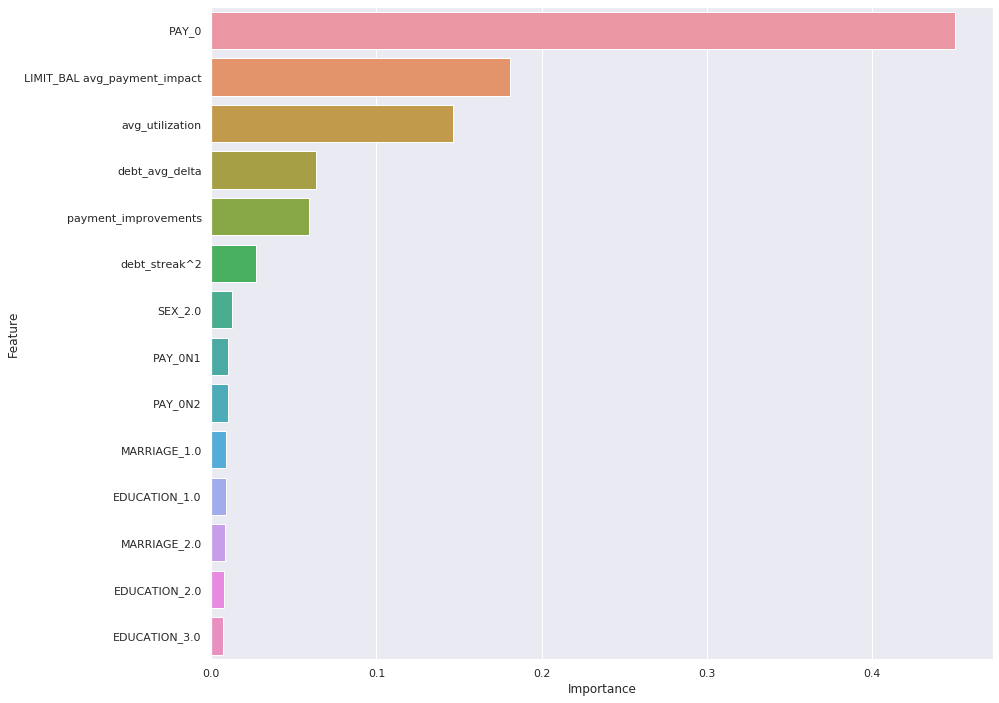

In [18]:
show_feature_importances(forest, data.get_X_train(), ascending=False, rows=14)